In this homework, you need to solve three tasks. The assignment should be uploaded in Jupyter Notebook format(`.ipynb`).

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sps

import scipy

%matplotlib inline

from sklearn.metrics.pairwise import rbf_kernel
from statsmodels.nonparametric.kernel_regression import KernelReg

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Matplotlib settings
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter

#jupyterlab
# %matplotlib widget 

#jupyter-notebook
# %matplotlib notebook 

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})

# Task 1. Model Selection (3 points)

In this task you will select model(choose set of covariates) using AIC criteria and forward/backward stepwise regression.

In [ ]:
import numpy.linalg as nla

from sklearn.preprocessing import MinMaxScaler

### Data loading and preprocessing

Read the dataset from file 'pacn_wrcc.csv'. The target variable is `ly Solar Rad.`, others are covariates. Get X and Y matrices.

In [ ]:
df = pd.read_csv('/content/sample_data/pacn_wrcc.csv')  
df

,mph Wind Speed,Deg Wind Direc,Deg F Av Air Temp,% Rel Humidty,volts Battery Voltage,Deg Dir MxGust,mph Mx Gust Speed,ly Solar Rad.,Deg F Mn Air Temp,Deg F Mx Air Temp,"Deg F 2"" Soil Ave Tmp","Deg F 4"" Soil Ave Tmp","Deg F 8"" Soil Av Temp","Deg F 20""Soil Av Temp"
0,4.428,49.350,59.96,88.2,12.52,85.0,16.240,5.748000,59.37,60.33,64.28,61.68,61.85,61.37
1,4.347,30.130,59.33,91.2,12.33,40.0,16.370,0.218700,58.52,59.73,63.61,61.77,61.65,61.25
2,4.592,35.970,58.60,89.7,12.26,163.0,21.540,0.007225,58.34,58.84,62.90,61.80,61.57,61.20
3,4.264,19.190,58.33,88.9,12.24,35.0,17.340,0.009203,58.05,58.72,62.36,61.74,61.47,61.14
4,3.755,8.620,58.19,89.6,12.22,164.0,16.890,0.006709,57.87,58.53,61.79,61.72,61.47,61.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,4.731,0.020,58.32,77.4,12.57,42.0,11.230,0.001634,57.76,58.79,61.63,63.74,63.31,61.92
296,4.421,1.703,56.72,87.2,12.55,37.0,7.852,0.003612,55.03,58.19,60.91,63.40,63.20,61.91
297,4.501,357.500,55.36,85.7,12.53,313.0,7.404,0.001462,54.42,56.00,60.44,63.12,63.14,61.95
298,3.910,358.300,55.64,88.0,12.51,357.0,7.606,0.000774,54.66,56.49,60.14,62.89,63.12,62.06


In [ ]:
Y = df['ly Solar Rad.']
print (Y)

0      5.748000
1      0.218700
2      0.007225
3      0.009203
4      0.006709
         ...   
295    0.001634
296    0.003612
297    0.001462
298    0.000774
299    0.000516
Name: ly Solar Rad., Length: 300, dtype: float64


In [ ]:
df.pop ('ly Solar Rad.')
X = np.copy (df)
print (X)

[[  4.428  49.35   59.96  ...  61.68   61.85   61.37 ]
 [  4.347  30.13   59.33  ...  61.77   61.65   61.25 ]
 [  4.592  35.97   58.6   ...  61.8    61.57   61.2  ]
 ...
 [  4.501 357.5    55.36  ...  63.12   63.14   61.95 ]
 [  3.91  358.3    55.64  ...  62.89   63.12   62.06 ]
 [  3.709  16.11   58.21  ...  62.72   63.1    62.19 ]]


Scale covariates to range `[0, 1]` and add bias column.

In [ ]:
X = np.concatenate ((np.ones (X.shape[0])[:, np.newaxis], X), axis=1)
print (X)

[[  1.      4.428  49.35  ...  61.68   61.85   61.37 ]
 [  1.      4.347  30.13  ...  61.77   61.65   61.25 ]
 [  1.      4.592  35.97  ...  61.8    61.57   61.2  ]
 ...
 [  1.      4.501 357.5   ...  63.12   63.14   61.95 ]
 [  1.      3.91  358.3   ...  62.89   63.12   62.06 ]
 [  1.      3.709  16.11  ...  62.72   63.1    62.19 ]]


In [ ]:
max_arr = np.amax(X, axis = 0)
X = X / max_arr
print (X)

[[1.         0.52216981 0.13712142 ... 0.96       0.97693887 0.9868146 ]
 [1.         0.51261792 0.0837177  ... 0.96140078 0.97377981 0.98488503]
 [1.         0.54150943 0.09994443 ... 0.9618677  0.97251619 0.98408104]
 ...
 [1.         0.5307783  0.99333148 ... 0.98241245 0.9973148  0.99614086]
 [1.         0.46108491 0.99555432 ... 0.97883268 0.99699889 0.99790963]
 [1.         0.43738208 0.04476243 ... 0.97618677 0.99668299 1.        ]]


### AIC and sample variance

Estimate sample variance of error with full set of covariates. Take into account number of dependent variables.

1) - Формула для многомерной линейной регрессии имеет вид:

$$\hat{r}(x) = \sum_{j = 1}^{k} \hat{\beta}_j x_j,$$
где $x$ - входной вектор с $x_1 = 1$, $\hat{\beta}$ - вектор коэффициентов многомерной линейной регрессии, k - число признаков.

2) - Коэффициенты линейной регрессии вычисляются по следующей формуле с регуляризацией Тихонова:

$$\hat{\beta} = (X^T X + λI)^{-1} X^T Y, $$
где $I$ - единичная матрица $k \times k$, $X$ - матрица входных значений $n \times k$, $Y$ - вектор выходных значений длины n, $n$ - число элементов в выборке, а $\lambda > 0$.

3) - Вектор невязки определяется следующим образом:

$$\hat{ϵ} = X\hat{\beta} - Y$$

4) - Неcмещённую оценку дисперсии можно вычислить по следующей формуле:

$$\hat{\sigma}^2 = \frac{\sum_{i = 1}^n \hat{ϵ}_i^2}{n - k}$$

In [ ]:
def get_beta (X, Y, lambd):
    inverse_matrix = np.linalg.inv (X.transpose () @ X + lambd * np.eye (X.shape[1]))
    return (inverse_matrix @ X.transpose ()) @ Y

def get_epsilon (X, Y, lambd):
    return X @ get_beta (X, Y, lambd) - Y

def get_variance (X, Y, lambd):
    assert X.shape[0] > X.shape[1]
    return np.sum (get_epsilon (X, Y, lambd)**2) / (X.shape[0] - X.shape[1])

In [ ]:
sigma2 = get_variance (X, Y, 0.00001)
print ("Variance is equal to {}".format (sigma2))

Variance is equal to 28.541797176894747


Implement estimate of AIC for given covariates, target and error variance.

1) - По критерию Акаики нужно максимизировать следующую величину:
$$AIC(S) = l_S (\hat {\beta}) - |S|,$$
где $S$ - это число признаков по которому надо максимизировать, а $l_S$ - логарифм правдоподобия.

2) - Логарифмм правдоподобия можно определить по следующей формуле из лекции:
$$l_S = ln \bigg(\prod\limits_{i = 1}^{n} f_{Y|X} (Y_i|X_i) \bigg).$$

3) - Будем считать, что шум в нашей системе - гауссовский с нулевым средним. Тогда можно записать следующую формулу:

$$f_{Y|X} (Y_i|X_i) = \frac{1}{\hat{\sigma} \sqrt{2\pi}} \exp \bigg(-\frac{(Y_i - \sum_{j=1}^S X_{ij} \hat{\beta_j})^2}{2 \hat{\sigma}^2}\bigg).$$

4) - В итоге, отбросив константы, которые не повлияют на процесс максимизации, мы получим, что надо максимизировать следующее выражение:

$$AIC(S) = -|S| - \frac{1}{2 \hat{\sigma}^2} \sum_{i=1}^n \bigg(Y_i - \sum_{j=1}^S X_{ij} \hat{\beta}_j \bigg)^2$$


In [ ]:
def aic (X, y, sigma2, alpha=0):
    beta = []
    if alpha == 0:
        beta = get_beta (X, y, 0.00001)
    else:
        beta = get_beta (X, y, alpha)
    
    S = X.shape[1]
    return -S - np.sum ((y - X @ beta) ** 2) / (2 * sigma2)

### Forward stepwise regression

Implement forward stepwise regression. Save the order in which covariates are added to feature set and AIC values for those feature sets.

In [ ]:
def forward_stepwise_regression(X, y, sigma2, alpha=0.):
    X_forward = []
    k = X.shape[1]
    optimal_aic = -1000000
    aic_values = []
    order = []    
    empty_indexes = np.arange (0, k, 1)
    new_ind = -1
    final_S = 1

    for S in range (1, k + 1, 1):
        current_aic = optimal_aic
        for ind in range (empty_indexes.size):
            aic_save = current_aic
            concat_matrix = [[]]
            if len (X_forward) == 0:
                concat_matrix = (X[:, empty_indexes[ind]])[:, np.newaxis]
            else:  
                concat_matrix = np.concatenate ((X_forward, (X[:, empty_indexes[ind]])[:, np.newaxis]), axis=1)
            current_aic = aic (concat_matrix, y, sigma2, alpha)

            if current_aic > aic_save:
                new_ind = ind
            else:
                current_aic = aic_save

        if optimal_aic < current_aic:
            optimal_aic = current_aic
            order.append (empty_indexes[new_ind] + 1)
            aic_values.append (optimal_aic)

            if len (X_forward) == 0:
                X_forward = (X[:, empty_indexes[new_ind]])[:, np.newaxis]
            else:
                X_forward = np.concatenate ((X_forward, (X[:, empty_indexes[new_ind]])[:, np.newaxis]), axis=1)
            empty_indexes = np.delete (empty_indexes, new_ind)
            final_S = S
        else:
            break

    return (final_S, aic_values, order)        

In [ ]:
(final_S, aic_values_forward, order) = forward_stepwise_regression(X, Y, sigma2, alpha=0.00001)
print ("The obtained value of S = {}".format (final_S))
print ("Order in which covariates are added : {}".format (order))
print ("AIC values: {}".format (aic_values_forward))

The obtained value of S = 10
Order in which covariates are added : [10, 12, 2, 6, 5, 8, 1, 4, 9, 3]
AIC values: [-1527.776056308991, -290.22600613538054, -258.52096098795374, -236.38233903059685, -205.12367722008042, -190.99593245552978, -179.8456046640392, -170.60684509465537, -159.92693937083337, -159.02304108272708]


### Backward stepwise regression

Implement backward stepwise regression. Save the order in which covariates are removed from feature set and AIC values for those feature sets.

In [ ]:
def backward_stepwise_regression(X, y, sigma2, alpha=0.):
    k = X.shape[1]
    optimal_aic = aic (X, y, sigma2, alpha)
    aic_values = [optimal_aic]
    order = []   
    deleted_indexes = []
    existing_indexes = [k for k in range (0, k, 1)]
    new_ind = -1
    final_S = k

    for S in range (k - 1, 0, -1):
        current_aic = optimal_aic
        for ind in range (len (existing_indexes)):
            aic_save = current_aic
            small_matrix = np.delete (X, deleted_indexes + [existing_indexes[ind]], axis = 1)   
            current_aic = aic (small_matrix, y, sigma2, alpha)

            if current_aic > aic_save:
                new_ind = ind
            else:
                current_aic = aic_save

        if optimal_aic < current_aic:
            optimal_aic = current_aic
            order.append (existing_indexes[new_ind] + 1)
            aic_values.append (optimal_aic)
            deleted_indexes += [existing_indexes[new_ind]]
            existing_indexes = np.delete (existing_indexes, new_ind)
            final_S = S
        else:
            break

    return (final_S, aic_values, order)      

In [ ]:
(final_S, aic_values_backward, order) = backward_stepwise_regression (X, Y, sigma2, alpha=0.00001)
print ("The obtained value of S = {}".format (final_S))
print ("Order in which covariates are removed: {}".format (order))
print ("AIC values: {}".format (aic_values_backward))

The obtained value of S = 11
Order in which covariates are removed: [2, 13, 7]
AIC values: [-157.0, -156.01766575672164, -155.13989292800244, -154.46316773743933]


### Bruteforce

Find best sets of covariates and their AIC for all sizes of feature sets.

In [ ]:
from itertools import combinations

def bruteforce (X, y, sigma2, alpha=0.):    
    k = X.shape[1]
    indexes = [k for k in range (0, k, 1)]
    best_deleted_indexes = [[0] * ind for ind in range (0, k, 1)]
    best_deleted_indexes[0] = []
    aic_vector = [aic (X, y, sigma2, alpha)] + [10000] * (k - 1)    

    for S in range (1, k, 1):
        combs = combinations (indexes, S)
        for elem in list (combs):
            X_small = np.delete (X, list (elem), axis = 1)
            aic_value = aic (X_small, y, sigma2, alpha)
            if aic_vector[S] == 10000:
                aic_vector[S] = aic_value
                best_deleted_indexes[S] = np.array (list (elem)) + 1
            else:
                if aic_value > aic_vector[S]:
                    aic_vector[S] = aic_value
                    best_deleted_indexes[S] = np.array (list (elem)) + 1


    # convert the best deleted indexes to the best indexes
    for ind1 in range (len (best_deleted_indexes)):
        tmp_array = []
        for ind2 in range (1, k + 1, 1):
            if ind2 not in best_deleted_indexes[ind1]:
                tmp_array.append (ind2)
        best_deleted_indexes[ind1] = np.array (tmp_array) 

    
    return (aic_vector, best_deleted_indexes)


In [ ]:
(aic_values_bruteforce, best_deleted_indexes) = bruteforce (X, Y, sigma2, alpha=0.00001)
print ("Indexes for best AIC values | Best AIC values")
for ind in range (len (aic_values_bruteforce)):
    print ("{} -> {}".format (best_deleted_indexes[ind], aic_values_bruteforce[ind]))

Indexes for best AIC values | Best AIC values
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] -> -157.0
[ 1  3  4  5  6  7  8  9 10 11 12 13 14] -> -156.01766575672164
[ 1  3  4  5  6  7  8  9 10 11 12 14] -> -155.13989292800244
[ 1  3  4  5  6  8  9 10 11 12 14] -> -154.46316773743933
[ 1  4  5  6  8  9 10 11 12 14] -> -155.55301877863192
[ 1  3  4  5  6  8  9 10 12] -> -158.02722532381472
[ 1  4  5  6  8  9 10 12] -> -158.94263807641394
[ 1  4  5  6  8  9 12] -> -162.6346867798459
[ 1  4  5  6  8 12] -> -168.7706104900553
[ 4  5  6  8 12] -> -179.61919313895893
[ 4  5  6 12] -> -203.07433700019732
[ 2 10 12] -> -258.52096098795374
[10 12] -> -290.22600613538054
[10] -> -1527.776056308991


[]


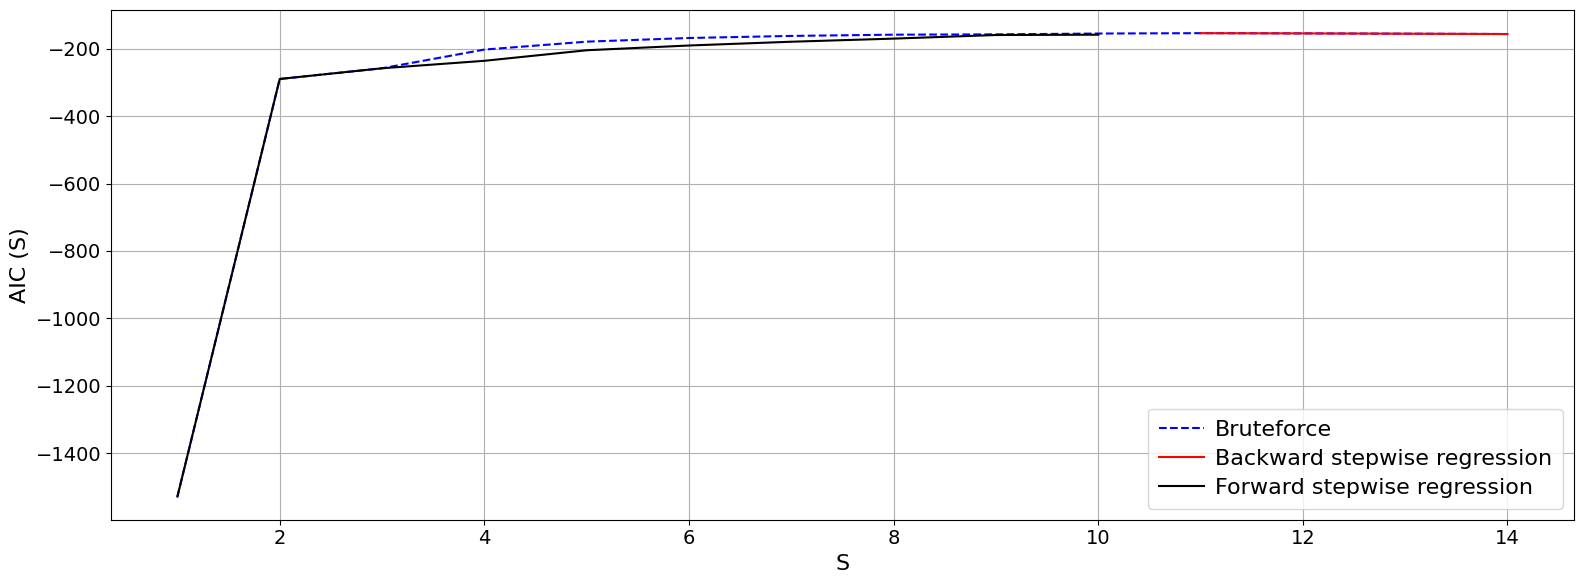

In [ ]:
plt.figure(figsize=[16, 6], dpi=100)

print (np.arange (len (aic_values_bruteforce) - len (aic_values_backward), len (aic_values_backward) + 1, 1))
plt.plot (np.arange (1, len (aic_values_bruteforce) + 1, 1), aic_values_bruteforce[len (aic_values_bruteforce) - 1::-1], 'b--', label='Bruteforce')
plt.plot (np.arange (len (aic_values_bruteforce) - len (aic_values_backward) + 1, len (aic_values_bruteforce) + 1, 1), 
          aic_values_backward[len (aic_values_bruteforce) - 1::-1], 'r-', label='Backward stepwise regression')
plt.plot (np.arange (1, len (aic_values_forward) + 1, 1), 
          aic_values_forward, 'k', label='Forward stepwise regression')
plt.xlabel('S')
plt.ylabel('AIC (S)')
plt.grid()
plt.tight_layout()
plt.legend ()

[]


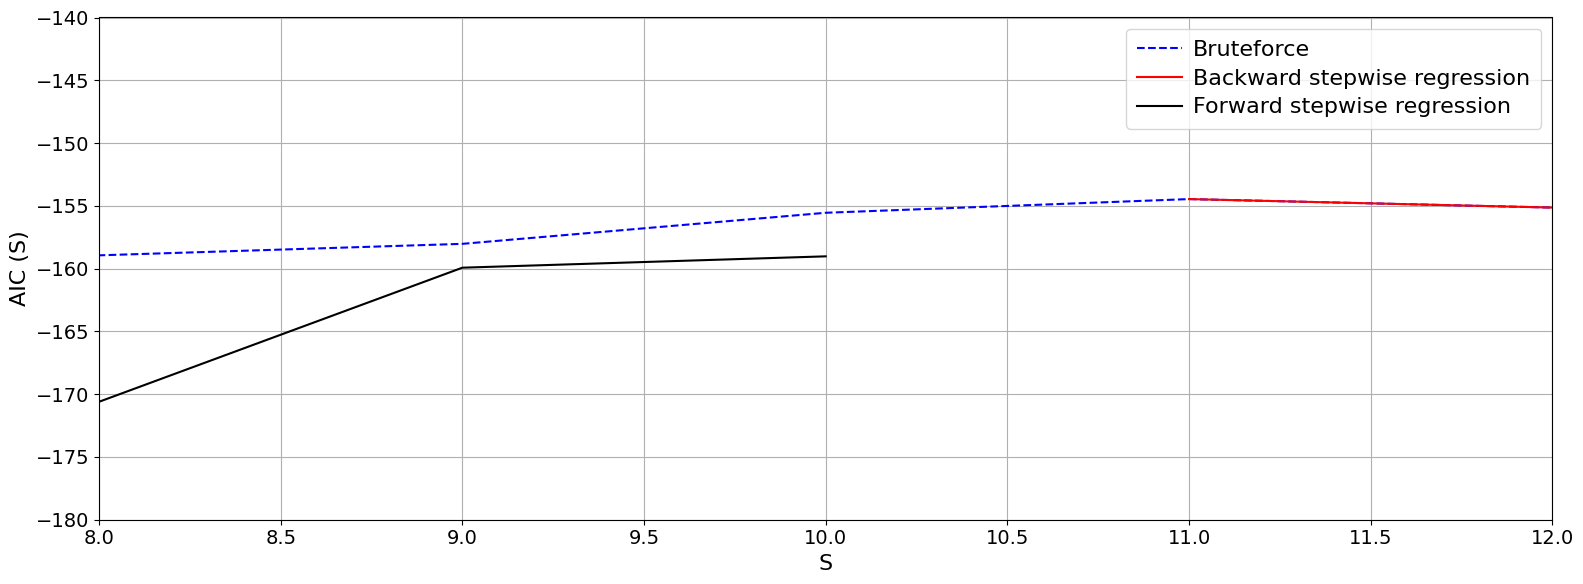

In [ ]:
plt.figure(figsize=[16, 6], dpi=100)

print (np.arange (len (aic_values_bruteforce) - len (aic_values_backward), len (aic_values_backward) + 1, 1))
plt.plot (np.arange (1, len (aic_values_bruteforce) + 1, 1), aic_values_bruteforce[len (aic_values_bruteforce) - 1::-1], 'b--', label='Bruteforce')
plt.plot (np.arange (len (aic_values_bruteforce) - len (aic_values_backward) + 1, len (aic_values_bruteforce) + 1, 1), 
          aic_values_backward[len (aic_values_bruteforce) - 1::-1], 'r-', label='Backward stepwise regression')
plt.plot (np.arange (1, len (aic_values_forward) + 1, 1), 
          aic_values_forward, 'k', label='Forward stepwise regression')
plt.xlabel('S')
plt.ylabel('AIC (S)')
plt.xlim ([8, 12])
plt.ylim ([-180, -140])
plt.grid()
plt.tight_layout()
plt.legend ()

Write your conclusions about conducted experiments.

Из результатов видно, что оптимальное число параметров равно $S = 11$, а максимальное значение метрики $AIC(S) = -154.46316773743933$. Также стоит отметить, что Backward stepwise regression дала точный результат, совпадающий с результатом brute force method. В свою очередь, Forward stepwise regression дала результат близкий к оптимальному $S = 10$, но всё же не совпадающий с ним. Можно заключить, что Backward stepwise regression и Forward stepwise regression могут значительно ускорить вычисления, но при этом дать результат несколько отличный от оптимального.


# Task 2. Local regression (3 points)

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.linear_model import LogisticRegression

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

You are given a sample of pairs $(X_i, Y_i)$. The output variable appers to be binary. We know a model for this type of data: logistic regression. In this model we assume the log-odds of the Bernoulli output variable to be a linear function:
$$\mathbb{P}(Y_i = 1 | X_i = x_i) = p(x_i) = \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$$

In [ ]:
X = np.array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18181818,
        1.24242424,  1.3030303 ,  1.36363636,  1.42424242,  1.48484848,
        1.54545455,  1.60606061,  1.66666667,  1.72727273,  1.78787879,
        1.84848485,  1.90909091,  1.96969697,  2.03030303,  2.09090909,
        2.15151515,  2.21212121,  2.27272727,  2.33333333,  2.39393939,
        2.45454545,  2.51515152,  2.57575758,  2.63636364,  2.6969697 ,
        2.75757576,  2.81818182,  2.87878788,  2.93939394,  3.        ])

In [ ]:
Y = np.array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

Lets fit a standard logistic regression to the data:

In [ ]:
logreg = LogisticRegression(penalty='none')
logreg.fit(X.reshape(-1, 1), Y)
p_pred_global = logreg.predict_proba(X.reshape(-1, 1))[:, 1]
print(f"Coefficients of the fitted logistic regression model: b0={logreg.intercept_[0]}, b1={logreg.coef_[0][0]}")

Coefficients of the fitted logistic regression model: b0=0.3769839468432626, b1=0.9109286874944


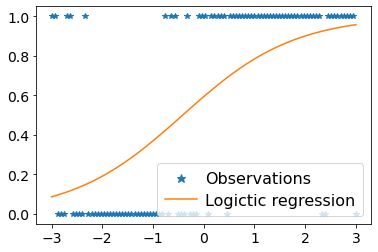

In [ ]:
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logictic regression')
plt.legend()

## Local regression

As we can see, the dependence of the outcome on $x$ looks more complex than estimated using logistic regression. We will try to improve it with local regression methods instead.
Instead of a global model, we will approximate conditinal probability of the positive class in a neighbourhood of $x$ with:
$$p(u) \approx \frac{e^{\beta_0 + \beta_1 (u-x) }}{1 + e^{\beta_0 + \beta_1 (u-x)}}, $$
for $u$ close to $x$. The coefficients in this case will depend on $x$. To find them, we will have to fit a (slightly different) model at each new query point $x_{new}$ (point where we want to predict $Y$). We will also need to introduce a notion of 'closenes' of points across $x$ - for this we can use our familiar *kernel functions*. Bringing everything together, we introduce the following local loglikelihood for our proposed model:
$$\ell_x(\beta) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right)\ell\left(Y_i, \beta_0 + \beta_1 \left(X_i - x\right)\right) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right) \left(Y_i \left(\beta_0 + \beta_1 \left(X_i - x\right)\right) - \log \left( 1 + e^{\beta_0 + \beta_1 \left(X_i - x\right)} \right) \right),$$
$$\ell(y, z) = yz - \log \left(1 + e^z \right).$$
Here $\ell(y, z)$ is a log-likelohood for a single Bernoulli with log-dds ratio $z = \frac{p}{1-p}$. The local log-likelihood $\ell_x(\beta)$ should be optimized numerically to each new point $x$ to obtain $\widehat{\beta}(x)=(\widehat{\beta_0}(x), \widehat{\beta_1}(x))$. Then, we can predict $Y$ using the logistic model:
$$ \mathbb{P}(Y=1 | X=x) = \frac{e^{\beta_0(x)}}{1 + e^{\beta_0(x)}}.$$
Your task is:
1. Implement the proposed local logistic regression approach using Gaussian kernel. *Hint*: look at additional parameters of the `fit` method of [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from `sklearn` package
2. Select optimal bandwidth using leave-one-out log-likelihood cross-validation: $\ell_{cv} = \sum_i \ell(Y_i, \widehat{z}_{-i}(x_i))$, where $\widehat{z}_{-i}$ is the estimated log-odds ratio without $i$th sample
3. Now ignore that the output variable is binary. Compare previous results with local linear kernel regression method using `KernelReg` from `statsmodels`. Use leave-one out squared error cross-validation to select the bandwidth
4. Summarize your findings

1. Implement the proposed local logistic regression approach using Gaussian kernel. *Hint*: look at additional parameters of the `fit` method of [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from `sklearn` package

In [ ]:
def gaussian_kernel (X, x, h):
    vector = (x - X) / h
    return np.exp (-vector**2 / 2) / np.sqrt (2 * np.pi)

def local_regression (Y, X, x, h):
    logisticRegr = LogisticRegression (solver = 'lbfgs')
    logisticRegr.fit ((X - x)[:, np.newaxis], Y, sample_weight = gaussian_kernel (X, x, h))  
  
    return logisticRegr.predict_proba ([[x]])[0][1]


2. Select optimal bandwidth using leave-one-out log-likelihood cross-validation: $\ell_{cv} = \sum_i \ell(Y_i, \widehat{z}_{-i}(x_i))$, where $\widehat{z}_{-i}$ is the estimated log-odds ratio without $i$th sample

In [ ]:
def get_mle (y, z):
    if z > 600:
        return (y - 1) * z
    else:
        return y * z - np.log (1 + np.exp (z))

def get_log_odds_ratio (p):
    return p / (1 - p)

def get_cross_validation_mle (Y, X, h):
    l_cv = 0
    for ind in range (X.size):
        X_punctured = np.delete (X, ind)
        Y_punctured = np.delete (Y, ind)
        logisticRegr = LogisticRegression (solver = 'lbfgs')
        logisticRegr.fit ((X_punctured - X[ind])[:, np.newaxis], Y_punctured, sample_weight = gaussian_kernel (X_punctured, X[ind], h))  
        p = logisticRegr.predict_proba ([[X[ind]]])[0][1]
        l_cv += get_mle (Y[ind], get_log_odds_ratio (p))
    
    return l_cv 

def get_optimal_bandwidth (Y, X, step, h_min, h_max):
    mle_array = []
    h_array = []
    h_opt = h_min
    h = h_min
    optimal_mle = 10000
    while (h < h_max):
        mle = get_cross_validation_mle (Y, X, h)
        if optimal_mle == 10000:
            optimal_mle = mle
            h_opt = h
        else:
            if mle > optimal_mle:
                optimal_mle = mle
                h_opt = h
        h_array.append (h)
        mle_array.append (mle)
        h += step

    return (h_opt, h_array, mle_array) 
         

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Optimal h = 1.0


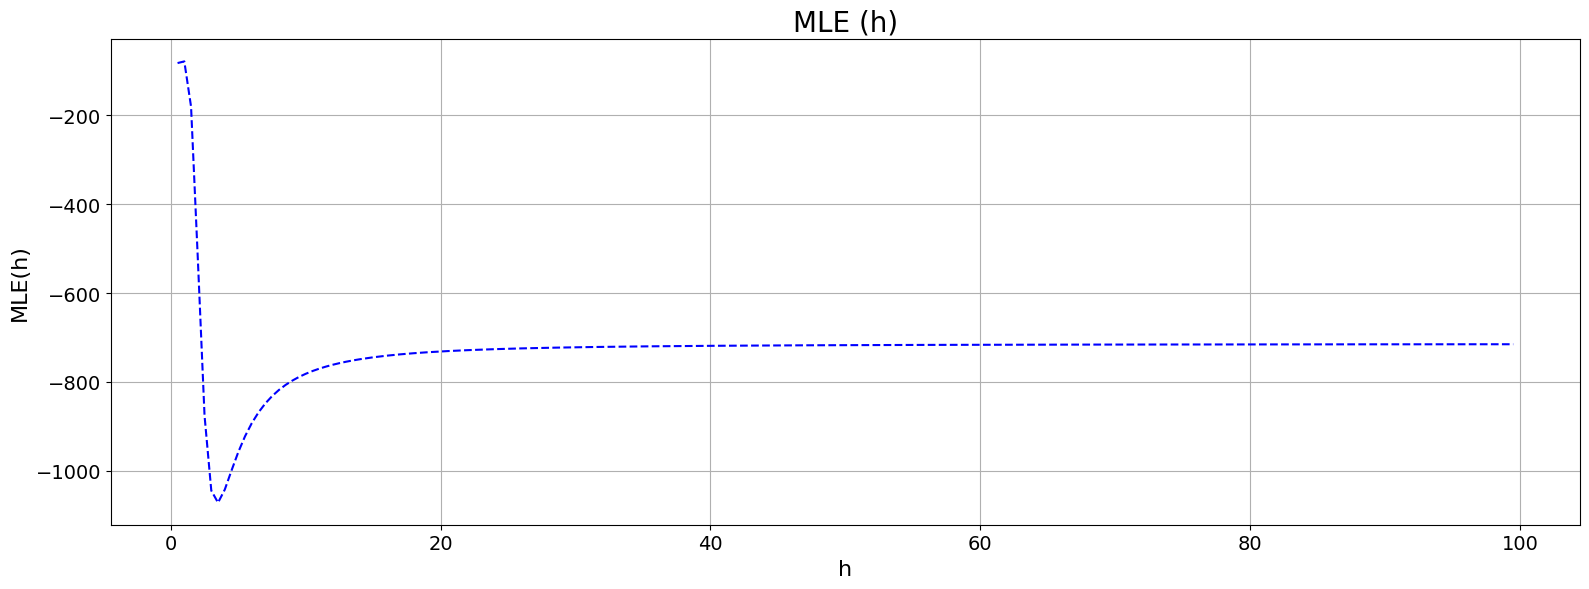

In [ ]:
(h, h_array, mle_array) = get_optimal_bandwidth (Y, X, 0.5, 0.5, 100)
plt.figure(figsize=[16, 6], dpi=100)
plt.plot (h_array, mle_array, 'b--')
plt.title('MLE (h)')
plt.xlabel('h')
plt.ylabel('MLE(h)')
plt.grid()
plt.tight_layout()

print ("Optimal h = {}".format (h))

Optimal h = 0.9300000000000006


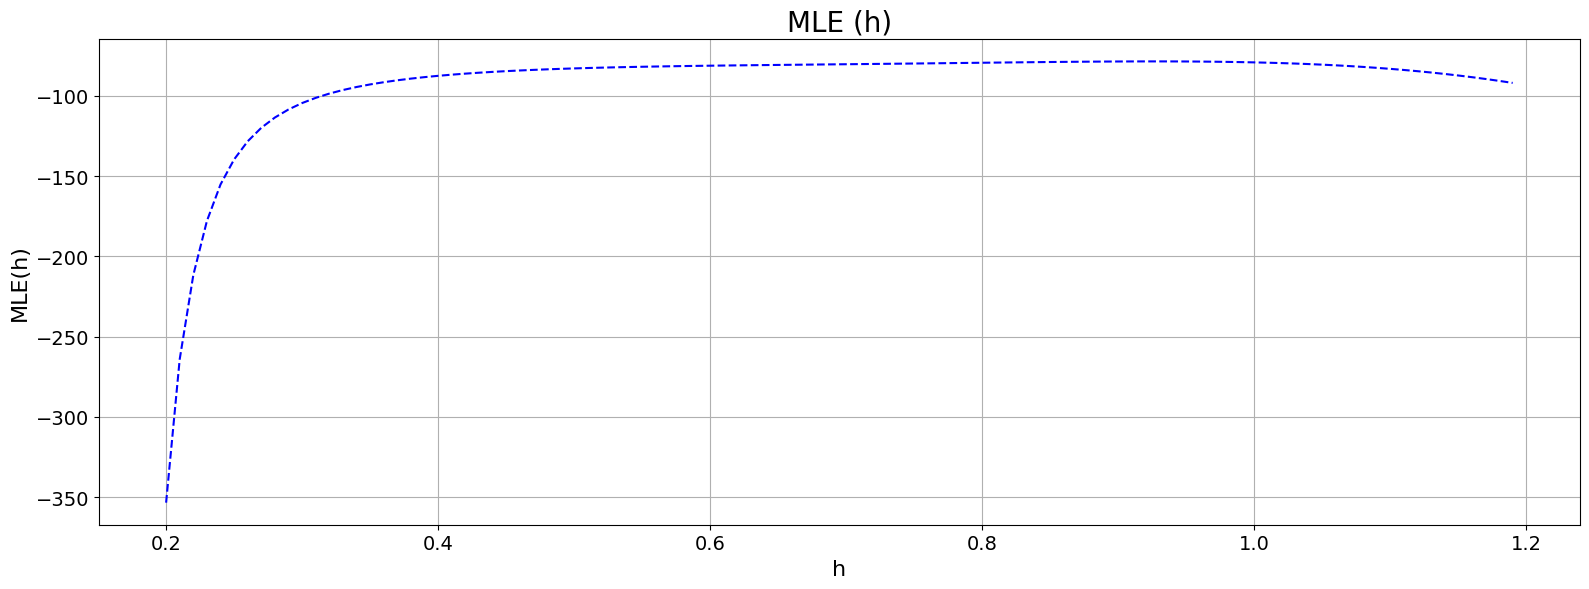

In [ ]:
(h, h_array, mle_array) = get_optimal_bandwidth (Y, X, 0.01, 0.2, 1.2)
plt.figure(figsize=[16, 6], dpi=100)
plt.plot (h_array, mle_array, 'b--')
plt.title('MLE (h)')
plt.xlabel('h')
plt.ylabel('MLE(h)')
plt.grid()
plt.tight_layout()

print ("Optimal h = {}".format (h))

В итоге оптимальное значение $h = 0.93$.

In [ ]:
results = []

for ind in range (X.size): 
    results.append (local_regression (Y, X, X[ind], 0.93))

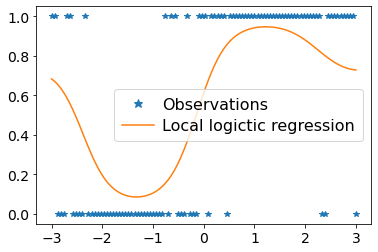

In [ ]:
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, results, label='Local logictic regression')
plt.legend ()

3. Now ignore that the output variable is binary. Compare previous results with local linear kernel regression method using `KernelReg` from `statsmodels`. Use leave-one out squared error cross-validation to select the bandwidth

In [ ]:
import math

def local_linear_regression (Y, X, h):
    kernelRegr = KernelReg (Y, X, 'c', reg_type='ll', bw=[h])
  
    return kernelRegr.fit (X)

In [ ]:
def get_optband_linearreg (Y, X):
    # h_array = [h_min + step * i for i in range (math.floor ((h_max - h_min) / step))]
    
    kernelRegr = KernelReg (Y, X, 'c', reg_type='ll', bw=[1])
    # lse_array = kernelRegr.cv_loo (bw=h_array, func=KernelReg._est_loc_linear (bw=h_array, endog=Y, exog=X ))
    h = kernelRegr._compute_reg_bw(bw="cv_ls")
    return h 
         

Optimal h = [0.58238942]


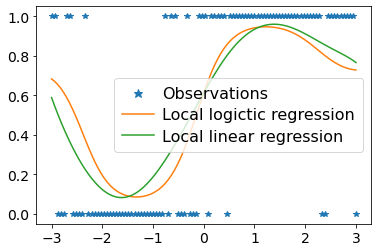

In [ ]:
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, results, label='Local logictic regression')
h = get_optband_linearreg (Y, X)
print ("Optimal h = {}".format (h))
plt.plot(X, local_linear_regression (Y, X, h)[:][0], label='Local linear regression')
plt.legend ()

4. Summarize your findings

Как видно, в некоторых случаях локальная логистическая регрессия может дать более точные результаты по сравнению с "глобальной логистической регрессией". Более того, более точных результатов можно достичь даже с помощью линейной регрессии с использованием ядра. В таком случае нужно просто использовать выход линейной регрессии как вероятность единички. 

## Task 3. Bayesian inference with MCMC (4 points)

In [3]:
import numpy as np
import scipy
import scipy.stats

import matplotlib.pyplot as plt

%matplotlib inline

from tqdm.auto import tqdm

We will consider a simple case of Bayesian inference for the unknown mean parameter of a Normal distribution. A series of values $\boldsymbol{X}^{(n)} = X_1, X_2, \dots X_n$ is sampled **independently** from a Normal distribution and we know its variance in advance, but are unsure about the mean. We assign a prior distribution to this unknown mean and would like to infer its posterior. We are also interested in predicting future observations $X$, so we would like to obtain its posterior predictive distribution as well.
$$\mu \sim \mathcal{N}(\mu_0, \sigma_0^2)$$
$$X_i | \mu \sim \mathcal{N}(\mu, \sigma^2), \; i=1 \dots n.$$

In [4]:
np.random.seed(31337)

true_mu = 3.0
true_std = 0.3
N = 20

prior_mu = 0.
prior_std = 1.

X = np.random.normal(true_mu, true_std, N)

### Task 3.1: implement analytical posterior (0.5 points)

$$p(\mu | \boldsymbol{X}^{(n)}) = \frac{p(\boldsymbol{X}^{(n)} | \mu) p(\mu)}{p(\boldsymbol{X}^{(n)})}, \label{eq1} \tag{1}$$
$$p(\boldsymbol{X}^{(n)}) = \int p(\boldsymbol{X}^{(n)}, \mu) d\mu$$
For our simple case it is actually possible to derive the exact posterior distibution of the mean analytically. Posterior distiribution of $\mu$ will also be Normal, but with different parameters that will depend on the observed sample and prior parameters. Refer to https://en.wikipedia.org/wiki/Conjugate_prior for the exact formulas and implement them in the following function:

1) - Из формул с википедии параметры для апостериорного распределения $P(\mu | X^{(n)})$ имеют следующий вид:

$$\mu^\prime = \frac{1}{\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}} \bigg( \frac{\mu_0}{\sigma_0^2} + \frac{\sum_{i=1}^n X_i}{\sigma^2} \bigg)$$

$$(\sigma^\prime)^2 = \bigg( \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\bigg)^{-1}$$

2) - Posterior predictive distribution:

$$p(x|X^{(n)}) = \int_{\mu} p(x|\mu) p(\mu|X^{(n)}) \,d\mu$$


3) - Из формул википедии параметры для posterior predictive distribution имеют вид:

$$\mu_p = \mu^\prime$$

$$\sigma_p^2 = (\sigma^\prime)^2 + \sigma^2$$

In [5]:


def analytical_posterior_pdf (x, samples, sigma, mu_0, sigma_0):
    """
    Probability density of the analytical posterior for the Normal model with known variance
    
    :param x: point(s) where to evaluate the density
    :param samples: observed samples
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p(mu | samples)(x)
    """
    
    sigma_p_squared = 1 / (1 / sigma_0**2 + samples.size / sigma**2)

    mu_first_part = mu_0 / sigma_0**2
    mu_second_part = np.sum (samples) / sigma**2
    mu_p = sigma_p_squared * (mu_first_part + mu_second_part)
  
        
    return scipy.stats.norm (mu_p, np.sqrt (sigma_p_squared)).pdf (x)

def predictive_posterior_pdf (x, samples, sigma, mu_0, sigma_0):
    """
    Probability density of the analytical posterior for the Normal model with known variance
    
    :param x: point(s) where to evaluate the density
    :param samples: observed samples
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p(mu | samples)(x)
    """
    
    sigma_prime_squared = 1 / (1 / sigma_0**2 + samples.size / sigma**2)
    sigma_p = np.sqrt (sigma_prime_squared + sigma**2)

    mu_first_part = mu_0 / sigma_0**2
    mu_second_part = np.sum (samples) / sigma**2
    mu_p = sigma_prime_squared * (mu_first_part + mu_second_part)
  
        
    return scipy.stats.norm (mu_p, sigma_p).pdf (x)

Сперва построим график для плотности вероятности posterior predictive distribution и сравним его с реальной плотностью вероятности, чтобы валидировать результаты.

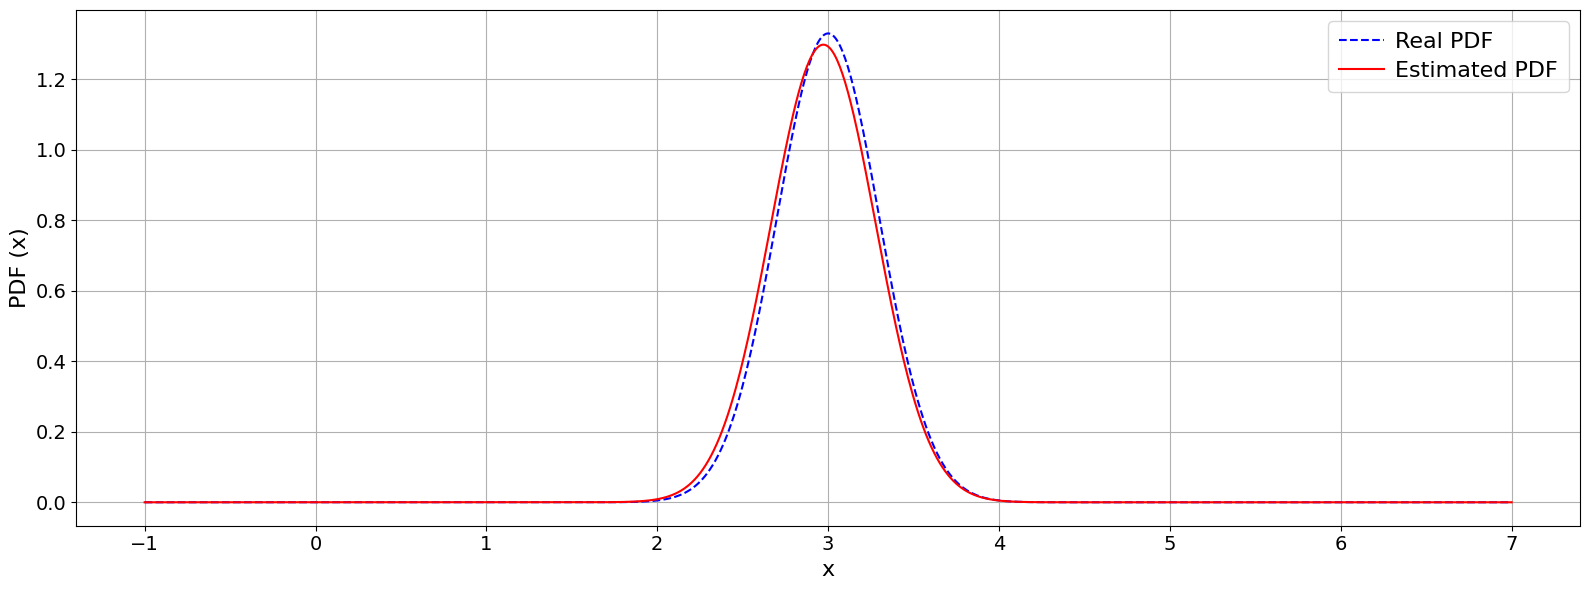

In [ ]:
plt.figure(figsize=[16, 6], dpi=100)

x_values = np.linspace (true_mu - 4, true_mu + 4, 1000)
plt.plot (x_values, scipy.stats.norm (true_mu, true_std).pdf (x_values), 'b--', label='Real PDF')
plt.plot (x_values, predictive_posterior_pdf (x_values, X, true_std, prior_mu, prior_std), 'r', label='Estimated PDF')
plt.xlabel('x')
plt.ylabel('PDF (x)')
plt.grid()
plt.tight_layout()
plt.legend ()

Plot the resulting analytical posterior for the given observed sample, standard deviation of $X_i$ and prior parameters.

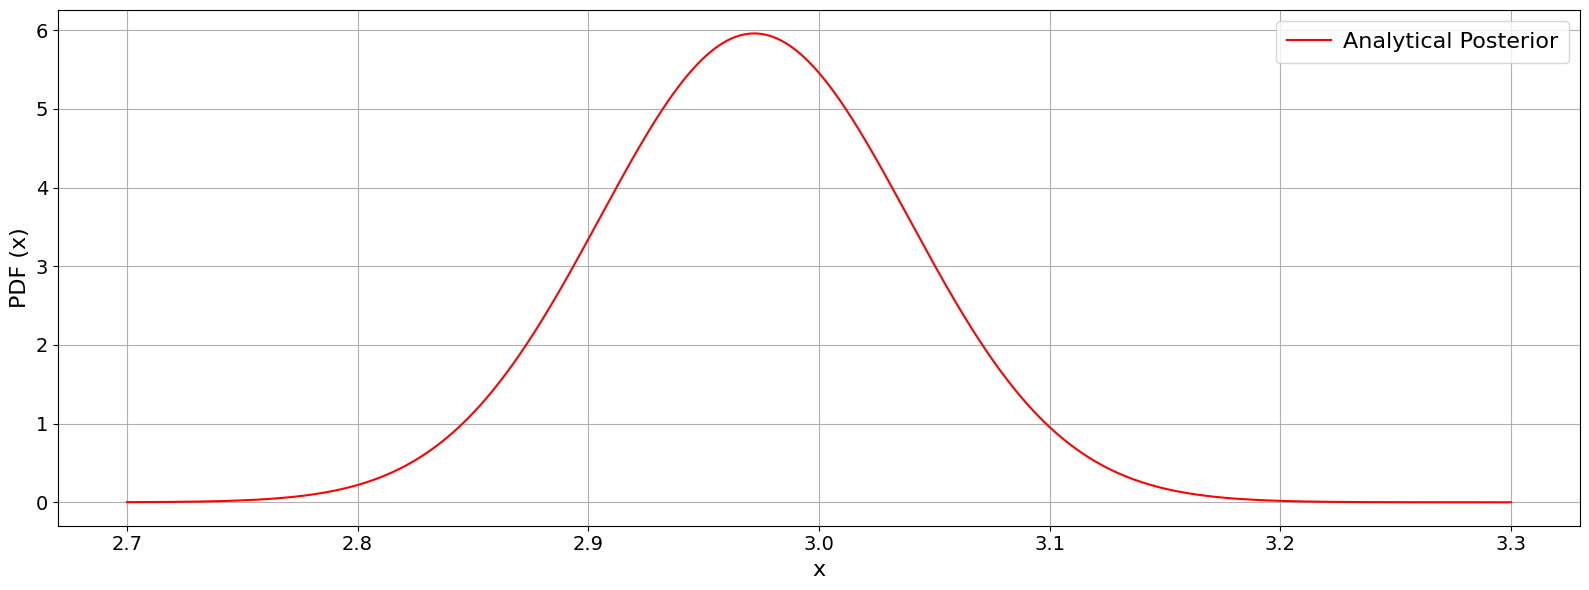

In [ ]:
plt.figure(figsize=[16, 6], dpi=100)

x_values = np.linspace (true_mu - 0.3, true_mu + 0.3, 1000)
plt.plot (x_values, analytical_posterior_pdf (x_values, X, true_std, prior_mu, prior_std), 'r', label='Analytical Posterior')
plt.xlabel('x')
plt.ylabel('PDF (x)')
plt.grid()
plt.tight_layout()
plt.legend ()

### Task 3.2: Metropilis-Hastings algorithm (2 points)

In more complex models it is usually infeasible to derive the exact formula for the posterior density. In the equation (1), the numerator contains easy to evaluate terms: prior and likelihood, while the denominator is rather hard to find. This means that we know our posterior only up to a constant multiplicative term. We will have to resort to approximations. Previously in the course we have studied methods to estimate the unknown density from samples. If we could sample from this unknown posterior, we might be able to approximate it using a histogram or a kernel method.

This is precisely the goal of MCMC methods. We will construct a Markov chain that will eventually produce samples from our distribution of interest - the posterior.


Markov chain is a sequence of random variables $Y_1, Y_2, \dots$ with the following property:
$$p(Y_k | Y_{k-1}, Y_{k-2}, \dots, Y_2, Y_1) = p(Y_k | Y_{k-1}),$$
wich means that subsequent values ($Y_k$) do not depend on the whole history of the sequence if the previous value ($Y_{k-1}$) is given.

We want to start with our chain from the prior distribution $Y_1 \sim p(\mu)$ and eventually converge to the posterior $Y_k \sim p(\mu | \boldsymbol{X}^{(n)})$. In order to achieve this, we need to define the transition probabilities $p(Y_k | Y_{k-1})$ in a special way. Intuitevely, it will depend on the prior and posterior in some way and there may be different possibilities.

We will describe one way to do it, namely Metropilis-Hastings algorithm with a random walk proposal. It was introduced in lecture 10, slides 19-22. We will use it to draw a sequence of samples from a special markov chain that satisfies our requirements.

Let $T$ be the number of steps we decided to take from the chan. For our example model and using our notation the algorithm outilines as follows:

1. Start by sampling $Y_1$ from the prior $p(\mu)$
2. Repeat for each $k$ form 1 to T:
3. Construct the next sample $Y_{k+1}$ given the previous sampled value $Y_k$:
4. $Y_{k+1} = Y_{k} + Z_{k+1}$, where $Z_{k+1} \sim \mathcal{N}(0, \sigma_{step}^2)$ (we take a sample)
5. We need to decide whether to make the transition $Y_k \rightarrow Y_{k+1}$ (accept or reject our *proposed* new value $Y_{k+1}$):
6. Accept the new sample with probability $\min \left\{1, \frac{p(\boldsymbol{X}^{(n)} | \mu = Y_{k+1}) p(\mu = Y_{k+1})}{p(\boldsymbol{X}^{(n)} | \mu = Y_{k}) p(\mu = Y_{k})}\right\}$, otherwise let $Y_{k+1} = Y_k$

Notice that our acceptance probability equals the ratio of the **posterior** probabilities: $\frac{p(\mu=Y_{k+1} | \boldsymbol{X}^{(n)})}{p(\mu=Y_k | \boldsymbol{X}^{(n)})}$, since the denominator in formula (1) does not depend on $\mu$. This allows us to skip the hard part of taking the integral. 

Your task is to implement these steps, including the calculation of the acceptance probability, and run the chain. Numpy array `Y` should contain one MCMC trajectory that you have obtained as the result.

*You may need to tune the $\sigma_{step}$ parameter.

In [6]:
def acceptance_prob(y_new, y_old, samples, sigma, mu_0, sigma_0):
    """
    Calculate acceptance probability in Metropilis-Hastings step for the Normal model with known variance
    :param y_new: proposed value (corresponds to Y_{k+1})
    :param y_old: previous value (corresponds to Y_k)
    :param samples: observed data (X^(n))
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p, acceptance probability
    """
    first_part = scipy.stats.norm (mu_0, sigma_0).pdf (y_new) / scipy.stats.norm (mu_0, sigma_0).pdf (y_old)

    old_distr = scipy.stats.norm (y_old, sigma)
    new_distr = scipy.stats.norm (y_new, sigma)
    second_part = 1
    for ind in range (samples.size):
        second_part *= new_distr.pdf (samples[ind]) / old_distr.pdf (samples[ind]) 

    r = first_part * second_part
    p = min (1, r)
    return p

In [7]:
T = 2000

sigma_step = 0.5

Y = np.empty (T)
acceptance_vector  = np.empty(T - 1)

Y[0] = np.random.normal (prior_mu, prior_std)

for i in tqdm (range(1, T)):
 
    Z = np.random.normal (0, sigma_step, 1)
    Y_next = Y[i - 1] + Z
    
    if np.random.rand () < acceptance_prob (Y_next, Y[i - 1], X, true_std, prior_mu, prior_std):
       acceptance_vector[i - 1] = 1
       Y[i] = Y_next
    else:
       acceptance_vector[i - 1] = 0
       Y[i] = Y[i - 1]
    pass

  0%|          | 0/1999 [00:00<?, ?it/s]

### Task 3.3: Visualize the results (0.5 point)
We have obtained a single trajectory of our Markov chain. The tsarting portion the obtained values may be different from the samples of the actual posterinir. After the so-called 'burn-in' or 'warmup' phase the distribution should become stationary and connverge to the true posterior. Time spent before this convergence occurs is usually called *mixing time*, and it is hard to estimate in practical situations.

1. Plot your trajectory using line chart: x-axis will be the timestep number and y-axis the sampled value

2. Plot the acceptance probability: how many proposed steps were accepted on average at given timestep (use sliding window or exponential moving average). Does it change over time? (You may need to save additional info during sampling in the previous part)

3. When do you think the 'mixing' occured? (Approximately)

1. Plot your trajectory using line chart: x-axis will be the timestep number and y-axis the sampled value

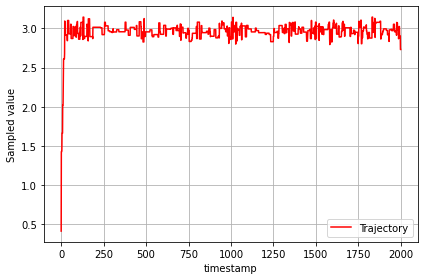

In [8]:
timestamps = np.arange (T)
plt.plot (timestamps, Y, 'r', label='Trajectory')
plt.xlabel('timestamp')
plt.ylabel('Sampled value')
plt.grid()
plt.tight_layout()
plt.legend ()

2. Plot the acceptance probability: how many proposed steps were accepted on average at given timestep (use sliding window or exponential moving average). Does it change over time? (You may need to save additional info during sampling in the previous part)

In [9]:
def get_exp_moving_average (array, new_weight):
    assert 0 <= new_weight <= 1.
   
    new_array = np.array ([0.] * array.size)
    new_array[0] = array[0]
    for ind in range (1, len (array)):
        new_array[ind] = new_weight * array[ind] + (1 - new_weight) * new_array[ind - 1]
    return new_array

No handles with labels found to put in legend.


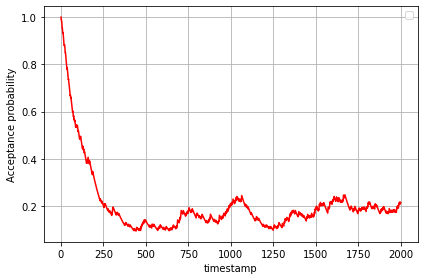

In [10]:
exp_moving_avg = get_exp_moving_average (acceptance_vector, 0.01)
if timestamps.size > exp_moving_avg.size:
    timestamps = np.delete (timestamps, 0)
plt.plot (timestamps, exp_moving_avg, 'r')
plt.xlabel('timestamp')
plt.ylabel('Acceptance probability')
plt.grid()
plt.tight_layout()
plt.legend ()

Как видно, acceptance probability меняется со временем. Сперва она быстро растёт (warm-up phase), а затем выходит на более или менее стабильное значение.

3. When do you think the 'mixing' occured? (Approximately)


No handles with labels found to put in legend.


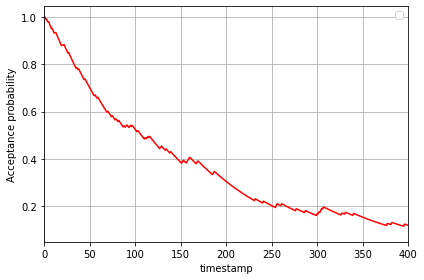

In [11]:
plt.plot (timestamps, exp_moving_avg, 'r')
plt.xlabel('timestamp')
plt.xlim([0, 400])
plt.ylabel('Acceptance probability')
plt.grid()
plt.tight_layout()
plt.legend ()

Исходя из графика, mixing происходит где-то на 300 отсчётах.

### Task 3.4: Approximate posterior (1 points)

Now we have determined the part of our trajectory that converged to our target distribution (you can use your guess from the previous task or just designate first half the trajectory for mixing). We will work with the remaing part to approximate the posterior.

1. Plot the histogram and kernel density estimator of the posterior using the samples from your MCMC run
2. Unfortunately, the samples that we obtained are not independent: due to the nature of our proposal step they are correlated. We can try to aleviate this effect by dropping some of the samples. Use only every 3rd (or 4th, 5th) obtained sample from the chain and display the corresponding distribution estimate on the same plot. Is it different?
3. Add theoretical posterior from part 1 to the same plot. Is it close to our estimate(s)?

1. Plot the histogram and kernel density estimator of the posterior using the samples from your MCMC run

Text(0, 0.5, 'PDF estimate through histogram')

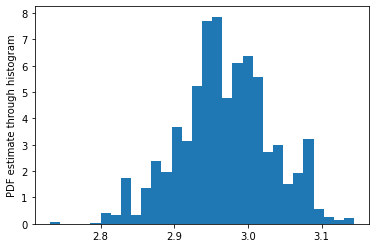

In [12]:
start_index = 300
Y_static = Y[start_index:]
plt.hist(Y_static, bins=30, density=True)
plt.ylabel('PDF estimate through histogram')

Text(0, 0.5, 'Gaussian kernel density estimation')

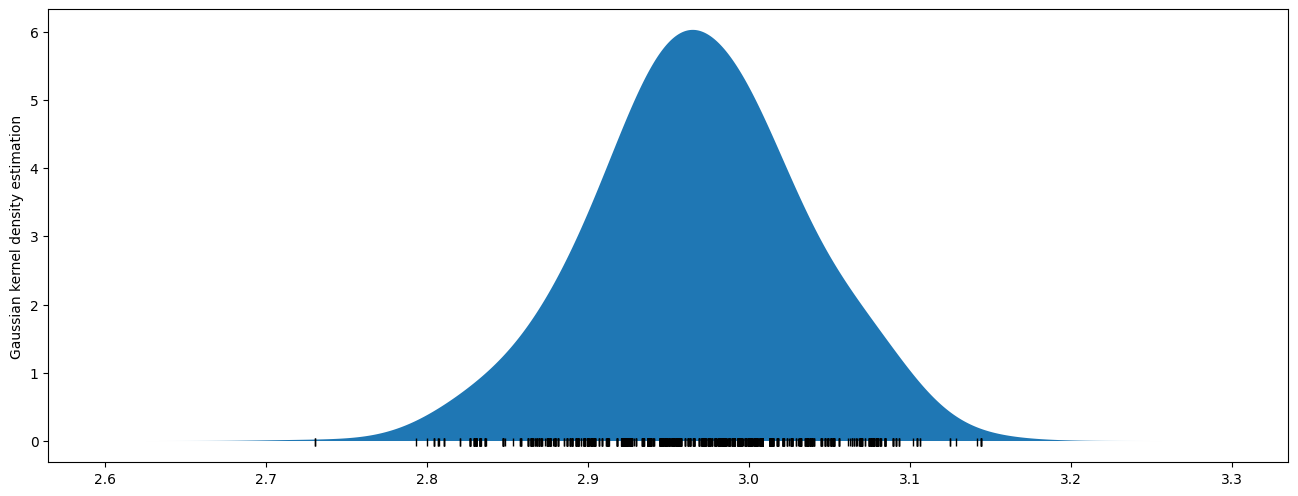

In [13]:
from sklearn.neighbors import KernelDensity

plt.figure(figsize=[16, 6], dpi=100)
x_values2 = np.linspace(2.6, 3.3, 1000)
kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
kde.fit(Y_static[:, None])
logprob = kde.score_samples(x_values2[:, None])

plt.fill_between(x_values2, np.exp (logprob), alpha=1)
plt.plot (Y_static, np.full_like (Y_static, -0.01), '|k', markeredgewidth=1)
plt.ylabel ("Gaussian kernel density estimation")

2. Unfortunately, the samples that we obtained are not independent: due to the nature of our proposal step they are correlated. We can try to aleviate this effect by dropping some of the samples. Use only every 3rd (or 4th, 5th) obtained sample from the chain and display the corresponding distribution estimate on the same plot. Is it different?

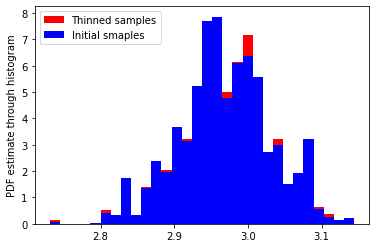

In [14]:
Y_thinned = Y_static[0:Y.size:3]
plt.hist(Y_thinned, bins=30, density=True, color='r', label='Thinned samples')
plt.hist(Y_static, bins=30, density=True, color='b', label='Initial smaples')
plt.ylabel('PDF estimate through histogram')
plt.legend ()

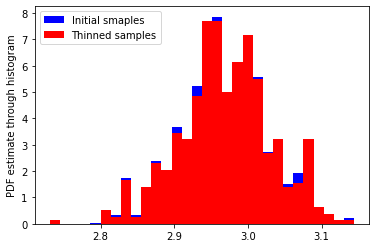

In [15]:
plt.hist(Y_static, bins=30, density=True, color='b', label='Initial smaples')
plt.hist(Y_thinned, bins=30, density=True, color='r', label='Thinned samples')
plt.ylabel('PDF estimate through histogram')
plt.legend ()

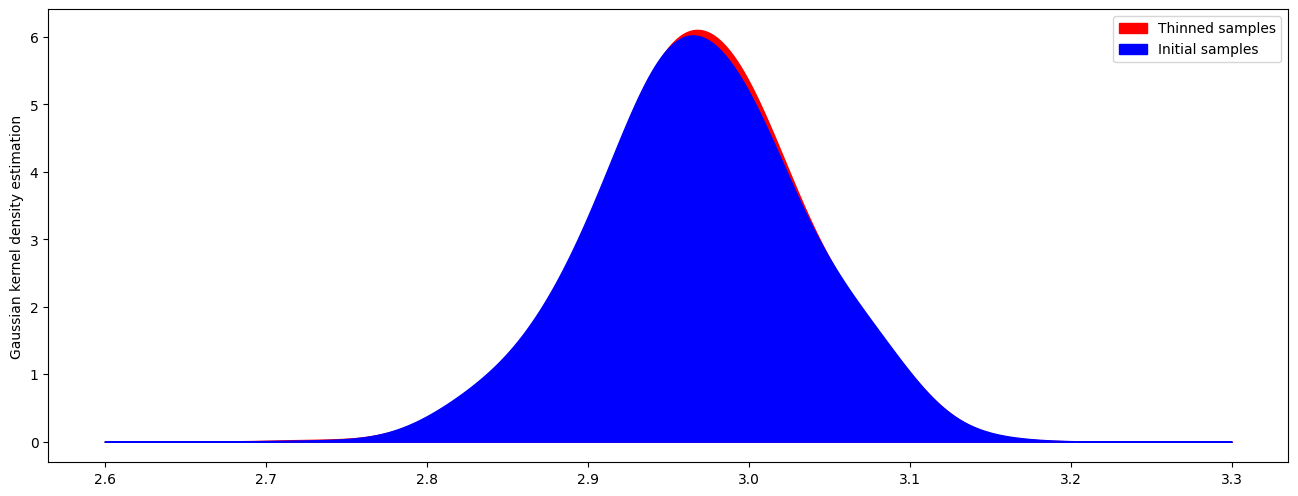

In [16]:
plt.figure(figsize=[16, 6], dpi=100)
x_values2 = np.linspace(2.6, 3.3, 1000)
kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
kde.fit(Y_static[:, None])
logprob_initial = kde.score_samples(x_values2[:, None])

kde.fit(Y_thinned[:, None])
logprob_thinned = kde.score_samples(x_values2[:, None])


plt.fill_between(x_values2, np.exp (logprob_thinned), alpha=1, label = 'Thinned samples', color='r')
plt.fill_between(x_values2, np.exp (logprob_initial), alpha=1, label = 'Initial samples', color='b')
plt.ylabel ("Gaussian kernel density estimation")
plt.legend ()

Как видно, прореживание выборки не изменило результат существенным образом.

3. Add theoretical posterior from part 1 to the same plot. Is it close to our estimate(s)?

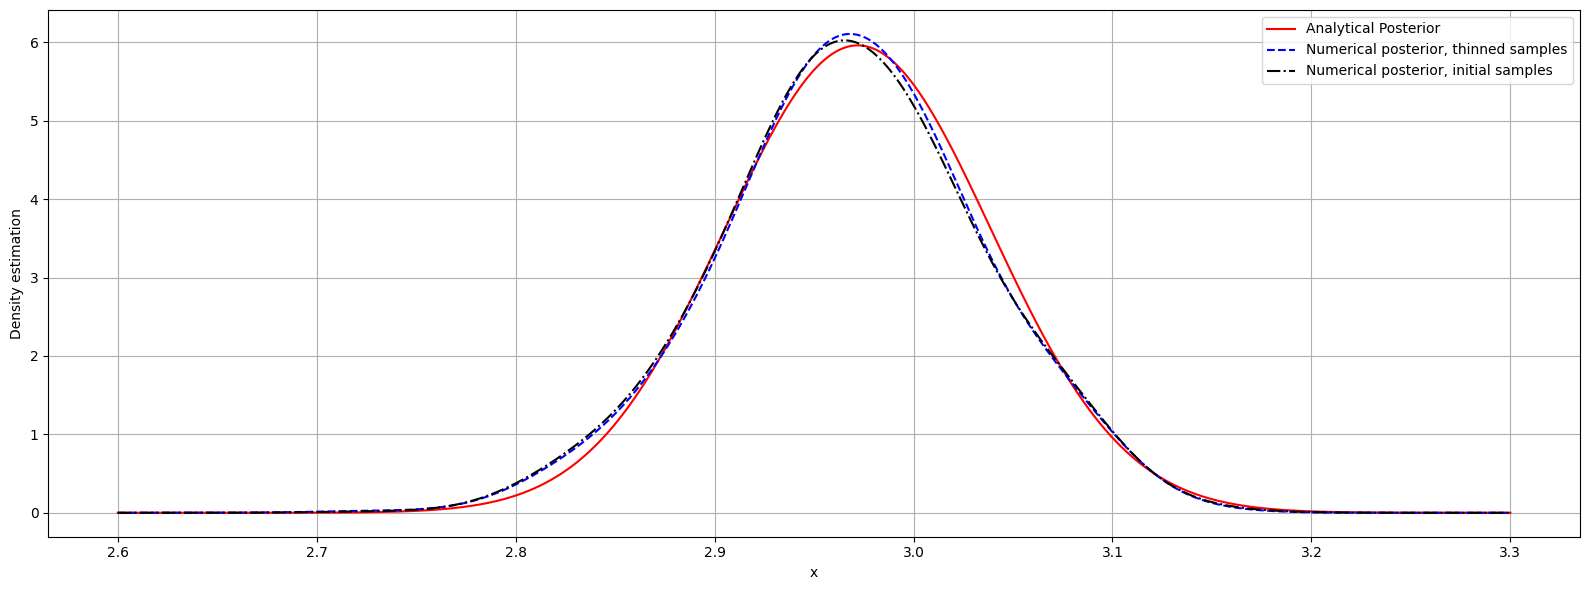

In [17]:
plt.figure(figsize=[16, 6], dpi=100)
plt.plot (x_values2, analytical_posterior_pdf (x_values2, X, true_std, prior_mu, prior_std), 'r', linestyle='-', label='Analytical Posterior')
plt.plot (x_values2, np.exp (logprob_thinned), label = 'Numerical posterior, thinned samples', color='b', linestyle = '--')
plt.plot (x_values2, np.exp (logprob_initial), label = 'Numerical posterior, initial samples', color='k', linestyle = '-.')
plt.ylabel ("Density estimation")
plt.legend ()
plt.xlabel('x') 
plt.grid()
plt.tight_layout()
plt.legend ()

Как видно, аналитические результаты довольно близки к численным.

### Task 3.5: Posterior predictive distribution (1 bonus point)

Now that we have obtained the estimate of the posterior, we can turn to a more practical task: predicting new values $X_{n+1}$. To do it in a Bayesian fashion, we employ posterior predictive distribution:
$$p(X_{n+1} | \boldsymbol{X}^{(n)}) = \int p(X_{n+1}, \mu | \boldsymbol{X}^{(n)}) d \mu = \int p(X_{n+1} | \mu, \boldsymbol{X}^{(n)}) p(\mu | \boldsymbol{X}^{(n)})d \mu = \int p(X_{n+1} | \mu) p(\mu | \boldsymbol{X}^{(n)})d \mu$$

Similar to part 1, for our simple model this distribution can also be derived analyticaly and is described on the same Wiki page.

1. Implement analytical posterior predictive distribution for our model and plot it
2. Using decorrelated samples from the posterior, obtained in the previous part, approximate the posterior predictive distribution (with histogram or KDE) and add it to the plot. Is it close to the analytical result?

1. Implement analytical posterior predictive distribution for our model and plot it

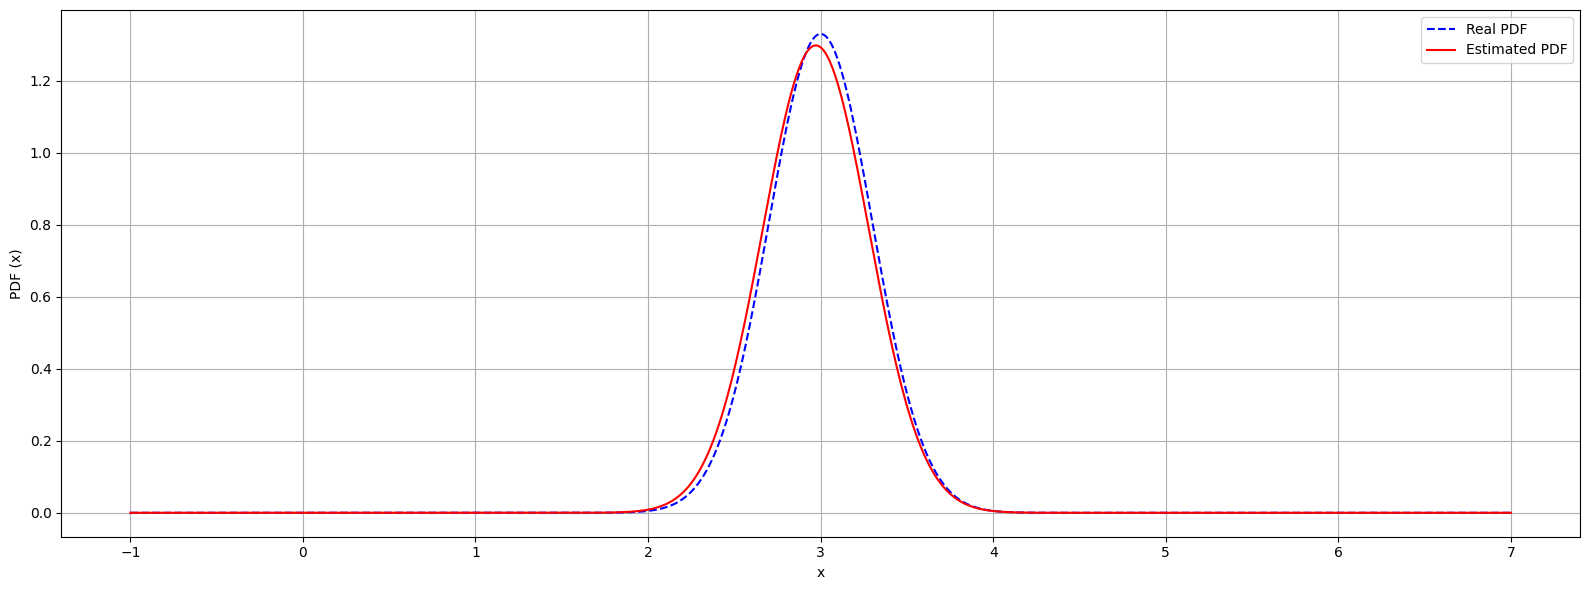

In [19]:
plt.figure(figsize=[16, 6], dpi=100)

x_values = np.linspace (true_mu - 4, true_mu + 4, 1000)
plt.plot (x_values, scipy.stats.norm (true_mu, true_std).pdf (x_values), 'b--', label='Real PDF')
plt.plot (x_values, predictive_posterior_pdf (x_values, X, true_std, prior_mu, prior_std), 'r', label='Estimated PDF')
plt.xlabel('x')
plt.ylabel('PDF (x)')
plt.grid()
plt.tight_layout()
plt.legend ()

2. Using decorrelated samples from the posterior, obtained in the previous part, approximate the posterior predictive distribution (with histogram or KDE) and add it to the plot. Is it close to the analytical result?

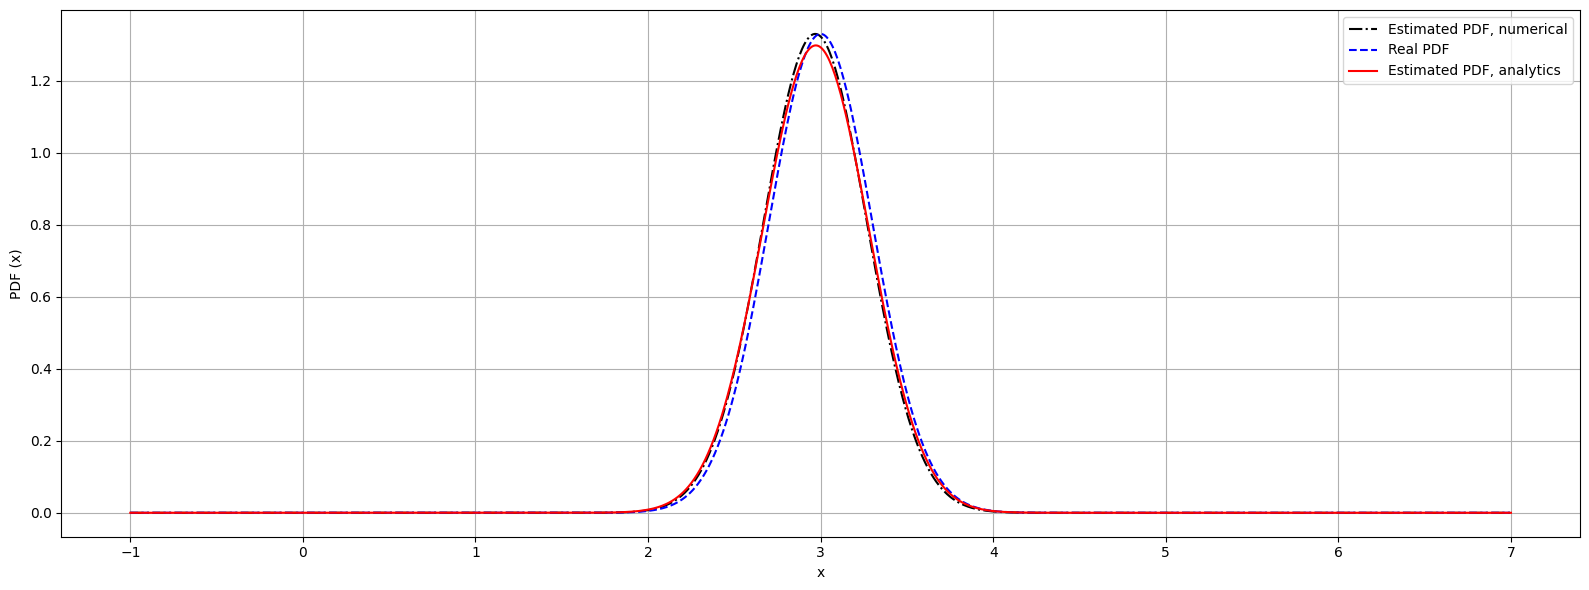

In [24]:
mu_estimated = np.mean (Y_thinned)
plt.figure(figsize=[16, 6], dpi=100)
x_values = np.linspace (true_mu - 4, true_mu + 4, 1000)
plt.plot (x_values, scipy.stats.norm (mu_estimated, true_std).pdf (x_values), 'k-.', label='Estimated PDF, numerical')
plt.plot (x_values, scipy.stats.norm (true_mu, true_std).pdf (x_values), 'b--', label='Real PDF')
plt.plot (x_values, predictive_posterior_pdf (x_values, X, true_std, prior_mu, prior_std), 'r', label='Estimated PDF, analytics')
plt.xlabel('x')
plt.ylabel('PDF (x)')
plt.grid()
plt.tight_layout()
plt.legend ()

Как видно, полученные результаты близки к аналитическим.

Теперь попробуем получить тот же результат, но с помощью KDE. Для этого сгенерируем выборку, используя известное среднее значение $\mu$.

<Figure size 1600x600 with 0 Axes>

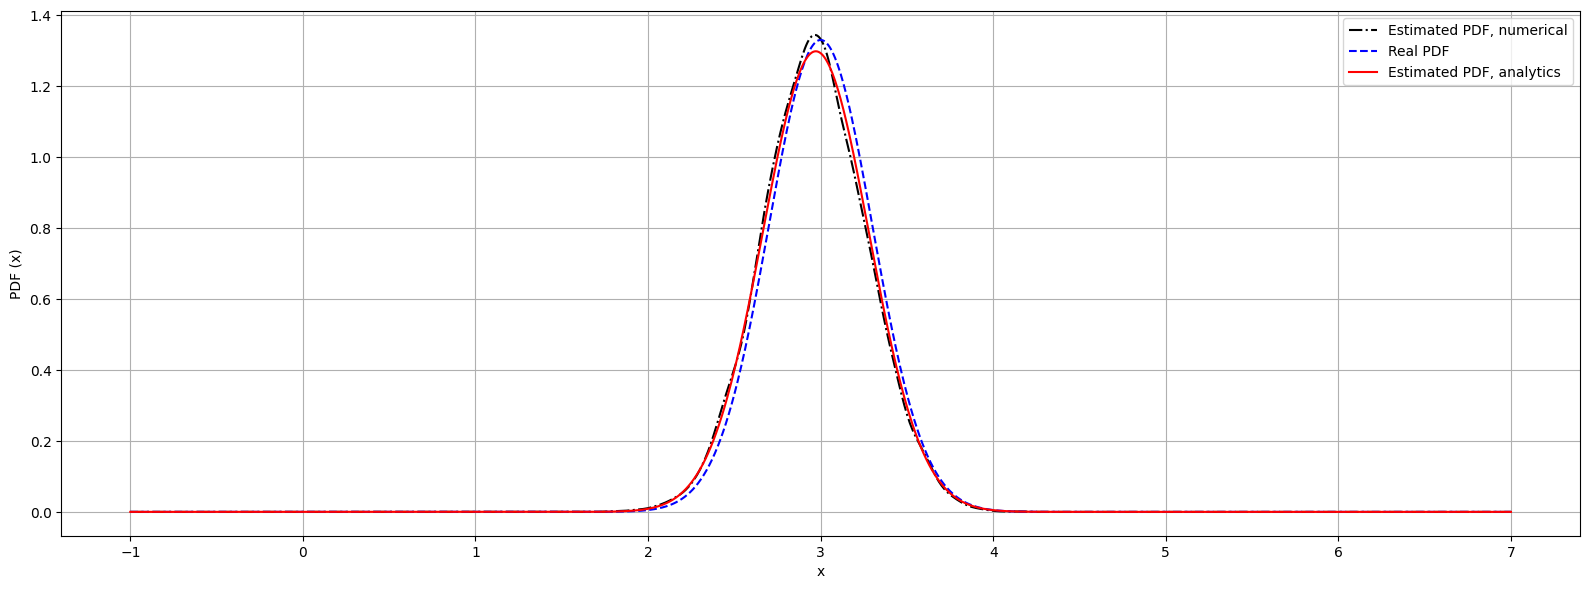

In [31]:
N_gen = 10
predicted_samples = np.random.normal (mu_estimated, true_std, Y_thinned.size * N_gen)

plt.figure(figsize=[16, 6], dpi=100)
kde_predicted = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde_predicted.fit (predicted_samples[:, None])
logprob_predicted = kde_predicted.score_samples(x_values[:, None])

plt.figure(figsize=[16, 6], dpi=100)
plt.plot (x_values, np.exp (logprob_predicted), 'k-.', label='Estimated PDF, numerical')
plt.plot (x_values, scipy.stats.norm (true_mu, true_std).pdf (x_values), 'b--', label='Real PDF')
plt.plot (x_values, predictive_posterior_pdf (x_values, X, true_std, prior_mu, prior_std), 'r', label='Estimated PDF, analytics')
plt.xlabel('x')
plt.ylabel('PDF (x)')
plt.grid()
plt.tight_layout()
plt.legend ()


Как видно, в данном случае результат также близок к реальному распределению.